In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import cv2
import uuid
import datetime
import numpy as np
import compress_pickle as cpkl

from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class
from ss_baselines.common.utils import plot_top_down_map

# Helper / tools
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING
def get_category_name(idx):
    assert idx >= 0 and idx <=20, f"Invalid category index number: {idx}"

    for k, v in CATEGORY_INDEX_MAPPING.items():
        if v == idx:
            return k

def get_current_ep_category_label(obs_dict):
    return get_category_name(obs_dict["category"].argmax())

In [15]:
DATASET_DIR_PATH = f"SAVI_Oracle_Dataset_v0"
# DATASET_DIR_PATH = f"SAVI_Oracle_Dataset_v0_10K" # Smaller scale dataset for tests

# Read the dataset statistics file.
dataset_stats_filepath = f"{DATASET_DIR_PATH}/dataset_statistics.bz2"
with open(dataset_stats_filepath, "rb") as f:
    r__dataset_stats = cpkl.load(f)

from pprint import pprint
pprint(r__dataset_stats)

{'action_cel_coefs': {0: 4.407133540153706,
                      1: 0.36458239159154604,
                      2: 2.1782260593810987,
                      3: 1.7508788515406162},
 'action_counts': {0: 28366, 1: 342893, 2: 57392, 3: 71400},
 'action_probs': {0: 0.056726213926179526,
                  1: 0.6857160569621898,
                  2: 0.11477229322609094,
                  3: 0.14278543588553969},
 'category_counts': {'bathtub': 107,
                     'bed': 626,
                     'cabinet': 2690,
                     'chair': 7256,
                     'chest_of_drawers': 685,
                     'clothes': 150,
                     'counter': 958,
                     'cushion': 2756,
                     'fireplace': 208,
                     'gym_equipment': 102,
                     'picture': 3438,
                     'plant': 1682,
                     'seating': 459,
                     'shower': 250,
                     'sink': 938,
                     'so

### Plotting some stats about the dataset

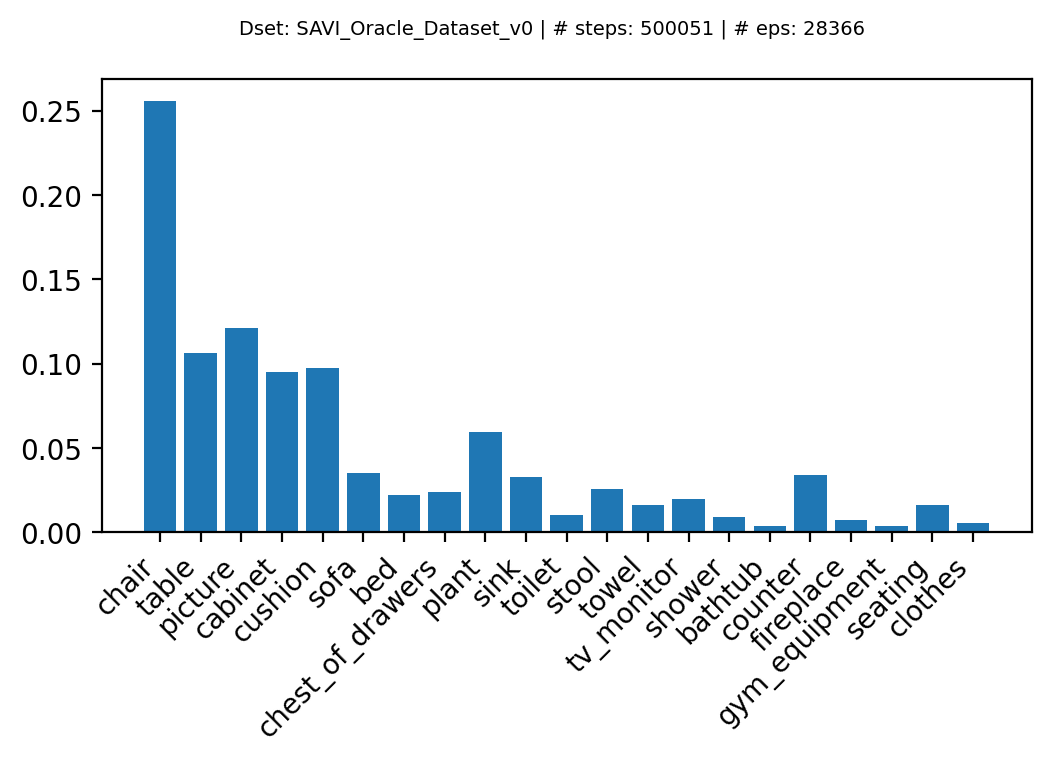

In [16]:
# Frequency of category counts
total_episodes = np.sum([v for k, v in r__dataset_stats["category_counts"].items()])
assert total_episodes == r__dataset_stats["total_episodes"], \
    "Category counts not matching episode counts."

category_probs = {k: v / total_episodes for k, v in r__dataset_stats["category_counts"].items()}
# pprint(category_probs)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
x=[i for i in range(21)]
x_labels, x_heights = [], []
for k, v in category_probs.items():
    x_labels.append(k)
    x_heights.append(v)
ax.bar(x=x, height=x_heights, tick_label=x_labels)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
fig.suptitle(f"Dset: {DATASET_DIR_PATH} | # steps: {r__dataset_stats['total_steps']} | # eps: {r__dataset_stats['total_episodes']}", fontsize=7)
fig.show()

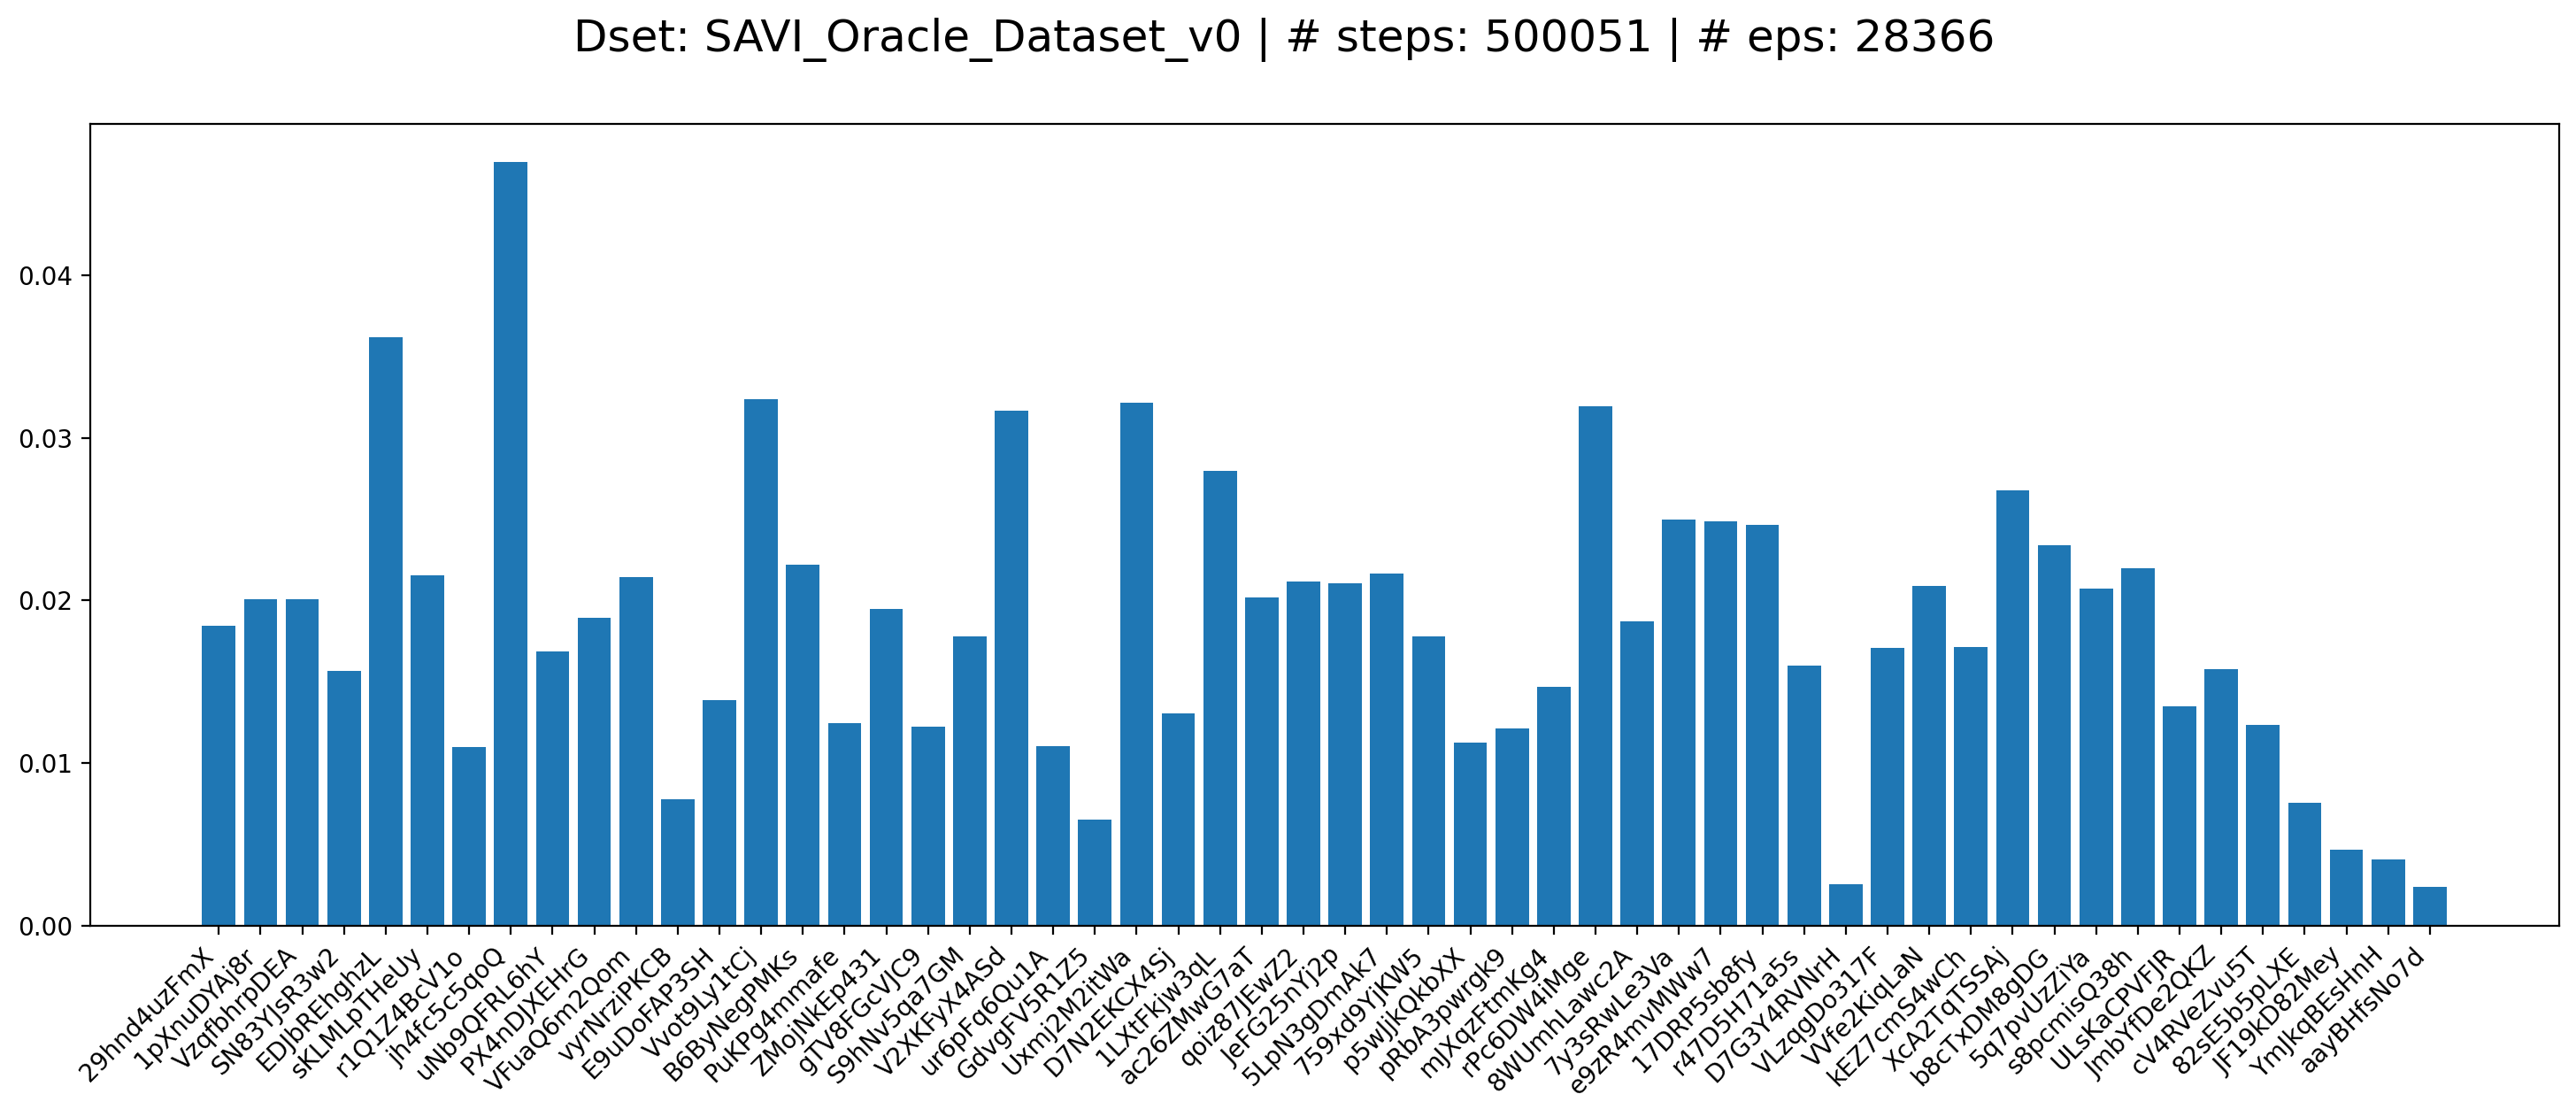

In [17]:
# Frequency of scenes in the dataset
total_episodes = np.sum([v for k, v in r__dataset_stats["scene_counts"].items()])
assert total_episodes == r__dataset_stats["total_episodes"], \
    "Scene counts not matching episode counts."
scene_probs = {k: v / total_episodes for k, v in r__dataset_stats["scene_counts"].items()}

fig, ax = plt.subplots(1,1, figsize=(6 * 3, 6), dpi=200)
x_labels, x_heights = [], []
for k, v in scene_probs.items():
    x_labels.append(k)
    x_heights.append(v)
n_scenes = len(x_labels)
x = [i for i in range(n_scenes)]

ax.bar(x=x, height=x_heights, tick_label=x_labels)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
fig.suptitle(f"Dset: {DATASET_DIR_PATH} | # steps: {r__dataset_stats['total_steps']} | # eps: {r__dataset_stats['total_episodes']}", fontsize=18)
fig.show()

In [8]:
# # Frequency of the episode lengths
# all_ep_lengths = []
# ep_lengths_dict = {}
# for ep_filename in os.listdir(DATASET_DIR_PATH):
#     if ep_filename == "dataset_statistics.bz2":
#         continue
#     ep_filepath = f"{DATASET_DIR_PATH}/{ep_filename}"
#     with open(ep_filepath, "rb") as f:
#         edd = cpkl.load(f)
    
#     ep_length = edd["ep_length"]
#     if ep_length not in list(ep_lengths_dict.keys()):
#         ep_lengths_dict[ep_length] = 1
#     else:
#         ep_lengths_dict[ep_length] += 1
#     all_ep_lengths.append(ep_length)

# # Histogram of the episodes lengths, note that it is very time costly, since this was not logged during data collection.
# fig, ax = plt.subplots(1,1, figsize=(6 * 3, 6), dpi=200)
# ax.hist(all_ep_lengths, bins=60)

# Extracting trajectories for RSA

### A. Same category, N trajs for M rooms

In [24]:
# Start byreading all the episodes in 
M = 2
N = 5
FIXED_CAT = "chair"

trajs_scenes_cat = {
    FIXED_CAT: {}
}

n_selected_trajs = 0

for ep_filename in os.listdir(DATASET_DIR_PATH):
    if ep_filename == "dataset_statistics.bz2":
        continue
    ep_filepath = f"{DATASET_DIR_PATH}/{ep_filename}"
    with open(ep_filepath, "rb") as f:
        edd = cpkl.load(f)

    ep_length = edd["ep_length"]
    ep_category = edd["category_name"]
    ep_scene = edd["scene_id"]

    # Skip if the category does not match
    if ep_category != FIXED_CAT:
        continue
    
    while n_selected_trajs < N * M:
        if ep_scene not in trajs_scenes_cat[FIXED_CAT].keys():
            # First time seeing the scene: add it to the dict, along with the new traj.
            trajs_scenes_cat[FIXED_CAT][ep_scene] = [
                {
                    "ep_filename": ep_filename,
                    "edd": edd
                }
            ]
            n_selected_trajs += 1
        else:
            # The scene was already seen once; check if we need more, and append accordingly
            if len(trajs_scenes_cat[FIXED_CAT][ep_scene]) < N:
                trajs_scenes_cat[FIXED_CAT][ep_scene].append({
                    "ep_filename": ep_filename,
                    "edd": edd
                })
                n_selected_trajs += 1

        print("### --------------------------------------------------- ###")
        print(f"### N selected traj: {n_selected_trajs}")
        for k, v in trajs_scenes_cat[FIXED_CAT].items():
            print(f"\t{k}: {len(v)}")
        print("### --------------------------------------------------- ###")
        print("")


    

In [21]:
edd.keys()

dict_keys(['obs_list', 'highres_obs_list', 'action_list', 'done_list', 'reward_list', 'info_list', 'ep_length', 'scene_id', 'category_idx', 'category_name'])